In [1]:
#meta 12/12/2020 Kaggle Cassava Model
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/cassava-leaf-disease-classification
#prev competition src https://www.kaggle.com/c/cassava-disease
#references https://arxiv.org/pdf/1908.02900.pdf

#input: kaggle files - images, csv with 5 cats
#output: submission.csv
#pwd: /kaggle/working

#history
#12/12/2020 MY INITIAL CODE - SMALL SAMPLE
#      Make sure submission works

#12/13/2020 MY INITIAL MODEL
#      Modeling with fast.ai
#      Make sure submission works with real size

#12/28/2020 MY MODEL TO SUBMIT
#      My sumbissions didn't work
#      Simulate test files and verify multiple submission - see part Xtra
#      Get rid of submission loop
#      1st successful submit with .779 accuracy

#here 01/03/2021 MODEL
#      dataprep: changed to DataBlock
#      item_tfms = Resize(128), batch_tfms = aug_transforms(mult=2) Ch2,pg74
#      model: cnn_learner(dls, resnet18, metrics=accuracy)
#      learn.fine_tune(10)
 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#modeling
from fastai.vision.all import *


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i=0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if not 'jpg' in filename:
            print(os.path.join(dirname, filename))
        else:
            
            if i<5:
                print (os.path.join(dirname, filename))
                i += 1

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train10-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train15-1327.tf

Global objects

In [3]:
#--constants and variables
SEED = 24

#--functions
#define label lookup 
def lookup_label(image_id): return int(df_train[df_train['image_id']== image_id]['label'])

#test function
#lookup_label('100042118.jpg')

# Cassava Disease Classification
##### Objective: Classify pictures of cassava leaves into 1 of 4 disease categories or healthy.

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.


## 0. Load Data

- Input: a dataset of 21,367 labeled images collected during a regular survey in Uganda.  
- Output: 5 categories, including healthy + 4 fine-grained cassava leaf disease categories

In [4]:
path = Path('../input/cassava-leaf-disease-classification')
path.ls()

(#7) [Path('../input/cassava-leaf-disease-classification/train_tfrecords'),Path('../input/cassava-leaf-disease-classification/sample_submission.csv'),Path('../input/cassava-leaf-disease-classification/test_tfrecords'),Path('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('../input/cassava-leaf-disease-classification/train_images'),Path('../input/cassava-leaf-disease-classification/train.csv'),Path('../input/cassava-leaf-disease-classification/test_images')]

### 0.1 Images  
21397 train images and 1 test image

In [5]:
(path/'train_images').ls(), (path/'test_images').ls()

((#21397) [Path('../input/cassava-leaf-disease-classification/train_images/1235188286.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1215607589.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/478554372.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2763304605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2826122413.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/111117998.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/231268038.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/4201965605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/3224710052.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1290729293.jpg')...],
 (#1) [Path('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')])

In [6]:
#load train/test images
train_img = get_image_files(path/'train_images')
test_img = get_image_files(path/'test_images')

print("Number of files: ", (len(train_img), len(test_img)))

Number of files:  (21397, 1)


### 0.2 Disease Labels Mapping

In [7]:
with open((path/'label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


### 0.3 Train Dataset

In [8]:
df_train = pd.read_csv(path/'train.csv')

print('train data\n', df_train.shape)
display(df_train.head())


train data
 (21397, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


0     1087
1     2189
2     2386
3    13158
4     2577
Name: label, dtype: int64


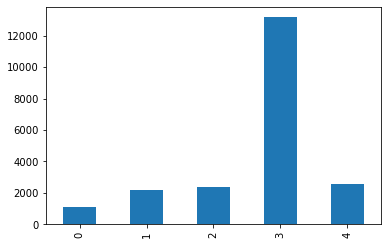

In [9]:
print(df_train['label'].value_counts().sort_index())
df_train['label'].value_counts().sort_index().plot(kind='bar');

1
../input/cassava-leaf-disease-classification/train_images/100042118.jpg


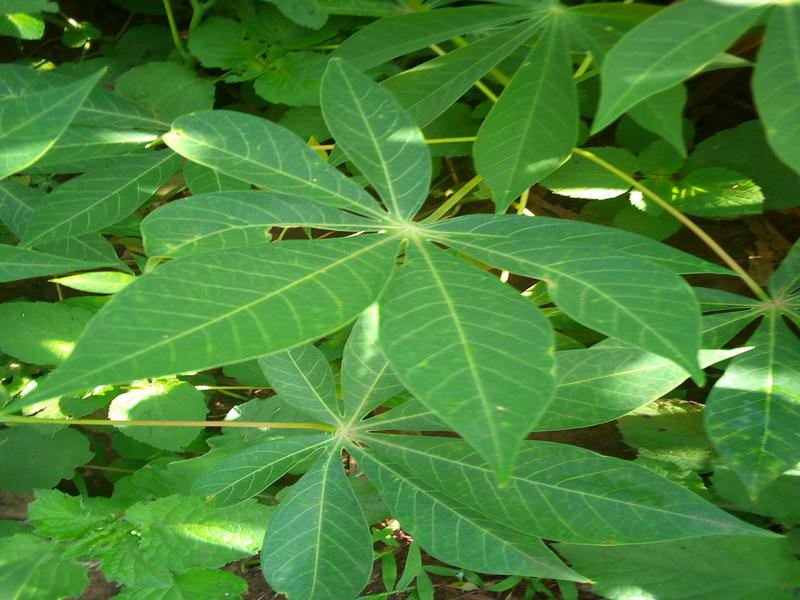

In [10]:
#view an image
image_example = '100042118.jpg'
print(lookup_label(image_example))
print(path/'train_images'/image_example)
Image.open(path/'train_images'/image_example)


## 1. Prep Data

### 1.1 From Data to Dataloaders
with DataBlock

path = Path('../input/cassava-leaf-disease-classification')

In [11]:
def get_x(row): return path/'train_images'/row['image_id']
def get_y(row): return row['label']

In [12]:
#dataloaders
dblk = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = get_x,
                 get_y = get_y,
                splitter=RandomSplitter(valid_pct=0.2, seed=SEED),
                 item_tfms = Resize(128), batch_tfms = aug_transforms(mult=2))
dls = dblk.dataloaders(df_train, bs=64)

len(dls.train_ds), len(dls.valid_ds)


(17118, 4279)

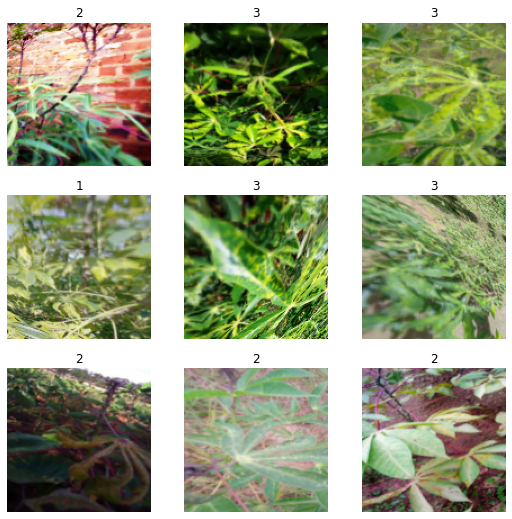

In [13]:
dls.show_batch()

## 2. Model
Learn a model to classify a given image into these 4 disease categories or a 5th category indicating a healthy leaf, using the images in the training data

### 2.0 Pretrained model offline

In [14]:
#src Daniel
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet185c106cdepth/resnet18-5c106cde.pth' '/root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth'

In [15]:
#if Internet enabled, download the pretrained model
#import torchvision.models as models
##arch = models.resnet18

#if Internet not enabled
#RESNET18_PATH = '/kaggle/input/resnet185c106cdepth/resnet18-5c106cde.pth'
#torch.load(resnet18, RESNET18_PATH)

### 2.1 Train 
Initial training 10 epochs.  Fine-tune after a successful submission

In [16]:
#mywas learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.310019,0.981141,0.660902,03:41


epoch,train_loss,valid_loss,accuracy,time
0,0.984226,0.824128,0.706941,03:18
1,0.879611,0.728013,0.736854,03:20
2,0.768905,0.712910,0.737556,03:21
3,0.721395,0.644063,0.769339,03:20
4,0.660313,0.661382,0.759991,03:19
5,0.620669,0.629221,0.765599,03:21
6,0.595466,0.604957,0.784295,03:19
7,0.553567,0.627281,0.771208,03:20
8,0.535784,0.612478,0.781958,03:22
9,0.520594,0.632116,0.770507,03:21


## 3. Predict
Predict on one file

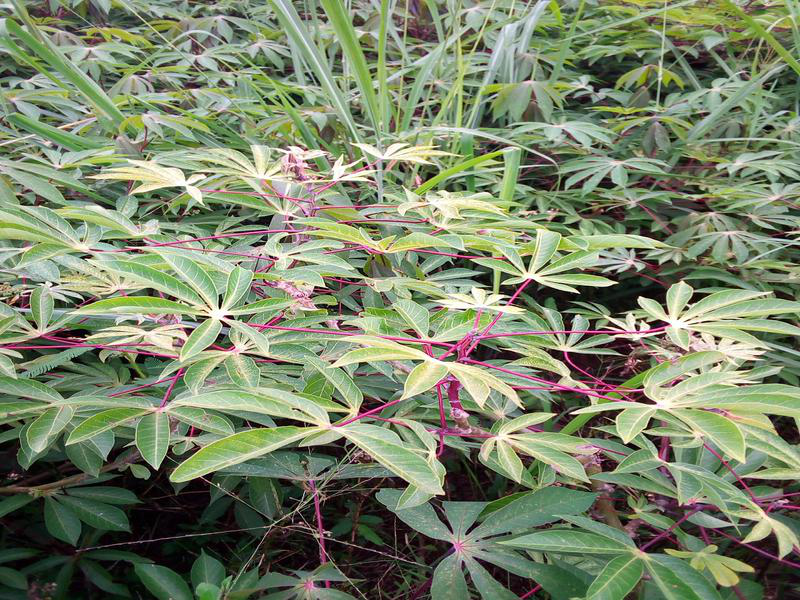

In [17]:
#view test images - only one
Image.open(test_img[0])

In [18]:
#predict one, returns a tuple, get 0th item
y_hat = learn.predict(test_img[0])[0]
y_hat

'2'

Test dataset

In [19]:
#create test images id

test_img_id = []

for f in test_img:
    #f_name = str(f).split("/")[-1]
    #print (f_name)
    test_img_id.append(f)

#images in test files
test_img_id

[Path('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')]

In [20]:
test_dl = dls.test_dl(test_img_id)
len(test_dl)

1

## 4. Submit


In [21]:
#template
sample_submission = pd.read_csv(path/'sample_submission.csv')
submission = sample_submission.copy()

#predict
preds,_ = learn.get_preds(dl=test_dl)
#preds

#submission
submission['image_id'] = [ str(item).split("/")[-1] for item in test_img_id]
submission['label'] = preds.argmax(dim=-1).numpy()
submission.head()


,image_id,label
0,2216849948.jpg,2


In [22]:
submission.to_csv('submission.csv', index=False)